# SIGN LANGUAGE DETECTION

#### Baseline Notebook

Author: Pragdheesh Ramaswamy Shanmugam - pr2179


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
import cv2
from tempfile import NamedTemporaryFile

In [ ]:
# Segmentation functions
import pixellib
from pixellib.semantic import semantic_segmentation
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("../input/ade20k/deeplabv3_xception65_ade20k.h5")

In [ ]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='************')

In [ ]:
!pip install pixellib

     |████████████████████████████████| 68 kB 1.6 MB/s eta 0:00:011
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16033 sha256=0fc7d49e659a1396b71b99c86cd7196e4381c16169fd8aab8aa3351758b3f192
  Stored in directory: /root/.cache/pip/wheels/da/7c/3e/296fe3ed4eb3bd713e91dee0d0549f12f316d49939a64bdc96
Successfully built imantics


In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train') #file name
file_paths = list(dir_.glob(r'**/*.jpg'))#names of elements in the file
print(len(file_paths))

In [ ]:
def increase_brightness(img, value=30):      #This function increases image brightness in the HSV color format
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img
def create_bucket(bucket_name):      # This function creates a Gogle Cloud Service bucket
    bucket = storage_client.create_bucket(bucket_name)
def upload_files(bucket_name, file_paths_list):    # Reads the image, does segmentation, increases teh brightness and then uploads it into GCS bucket
    bucket = storage_client.get_bucket(bucket_name)
    for filename in range(len(file_paths_list)-1, -1, -1):
        temp_name = str(file_paths_list[filename])
        segvalues, output = segment_image.segmentAsAde20k(temp_name)
        img = cv2.imread(temp_name)
        output_temp = (output[:,:] != [120,120,120])*img
        output_temp = increase_brightness(output_temp, value=70)
        temp_name = temp_name[41:]
        if filename%1000 == 0:
            print(temp_name)
        with NamedTemporaryFile() as temp:
            iName = "".join([str(temp.name),".jpg"])
            cv2.imwrite(iName,output_temp)
            blob = bucket.blob(temp_name)
            blob.upload_from_filename(iName,content_type='image/jpeg')
            url = blob.public_url
bucket_name = 'seg_data'
create_bucket(bucket_name)
upload_files(bucket_name, file_paths)

In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/segdata/asl_alphabet_train') #file name
file_paths = list(dir_.glob(r'**/*.jpg'))#names of elements in the file
print(len(file_paths))

In [ ]:
#create dataframe of the images
def create_frame(paths):
    #status: complete
    labels=[]
    ids=[]
    image_names=[]
    for i in range(len(paths)):
        image_path=str(paths[i])
        image_names.append(image_path)#elements names list
        path_elements=image_path.split("/")
        label=path_elements[-2]
        labels.append(label)#label list append
    df = pd.DataFrame({"img":image_names, "class":labels})
    return df

In [ ]:
np.unique(df['class']) #Check is data is read properly

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype=object)

                                               img class
0  ../input/segdata/asl_alphabet_train/N/N1337.jpg     N
1  ../input/segdata/asl_alphabet_train/N/N1637.jpg     N
2    ../input/segdata/asl_alphabet_train/N/N20.jpg     N
3   ../input/segdata/asl_alphabet_train/N/N222.jpg     N
4  ../input/segdata/asl_alphabet_train/N/N2785.jpg     N


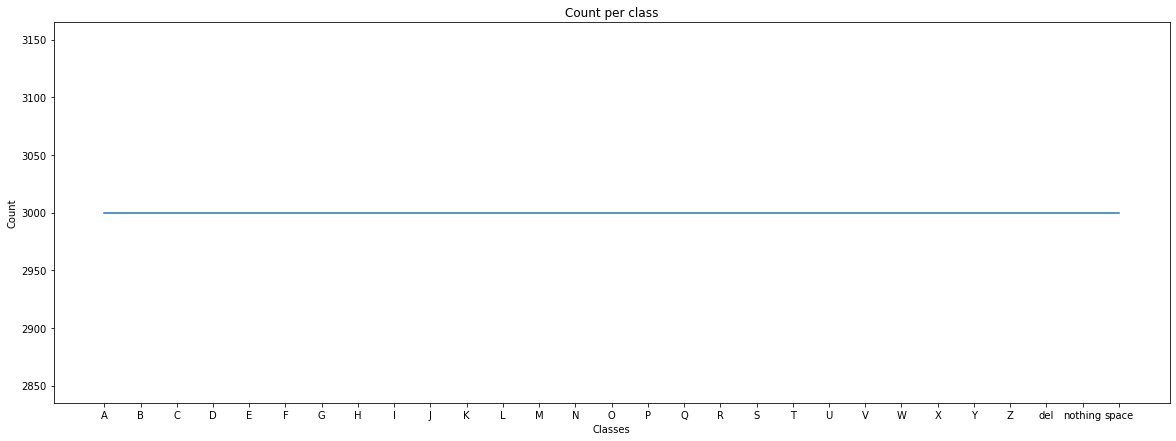

In [ ]:
#Create dataframe and evenly distributed data or not
df=create_frame(file_paths)
print(df.head())
part=df.groupby(['class']).size()
plt.figure(figsize=(20, 7))
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Count per class")
plt.plot(part)

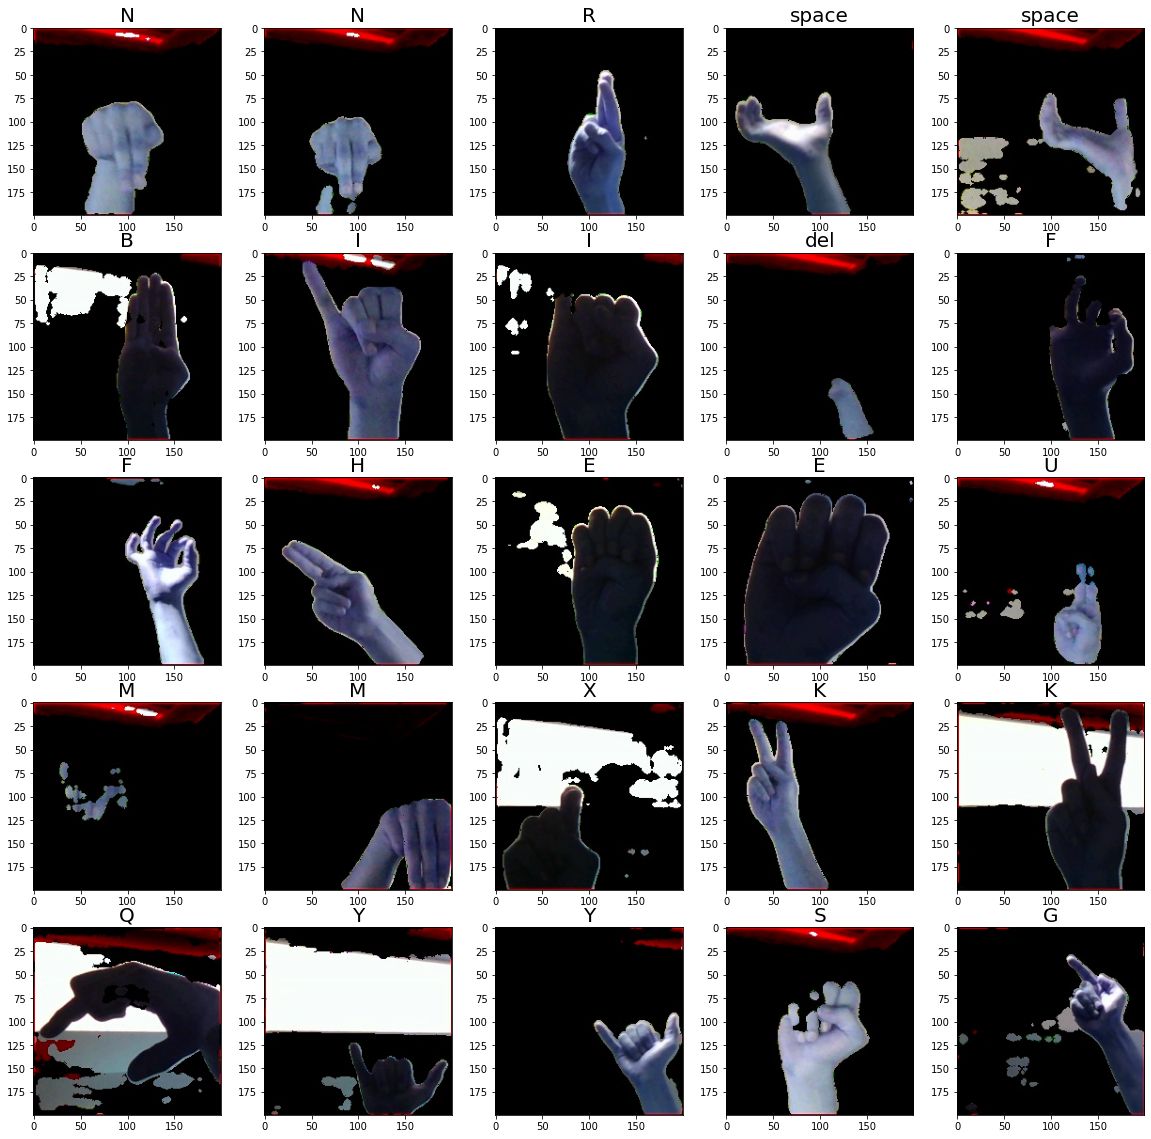

In [ ]:
#display different class images
figure, axs=plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.imread(df['img'][i*2000]))
    ax.set_title(df["class"][i*2000], fontsize=20)
plt.show()

In [ ]:
#split into train_test cases
train, test=train_test_split(df, test_size=0.2)

In [ ]:
def load_images(train, test):
    #create the train image generator objects
    train_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
    )
    #get images from the objects
    train_imgs=train_gen.flow_from_dataframe(
        dataframe=train,
        target_size=(224, 224),
        x_col="img",
        y_col="class",
        batch_size=50,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset="training"
    )
    #get validation images from the objects
    validation_imgs=train_gen.flow_from_dataframe(
        dataframe=train,
        target_size=(224, 224),
        x_col="img",
        y_col="class",
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset="validation"
    )
    #create test image generator objects
    test_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input        
    )
    #get images from the objects
    test_imgs=test_gen.flow_from_dataframe(
        dataframe=test,
        target_size=(224, 224),
        x_col="img",
        y_col="class",
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
        batch_size=50
    )
    return train_gen, test_gen, train_imgs, validation_imgs, test_imgs

#load images using this function
train_gen, test_gen, train_imgs, validation_imgs, test_imgs=load_images(train, test)

Found 62640 validated image filenames belonging to 29 classes.
Found 6960 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [ ]:
def create_model(model):
    # Creates the model and the model with the dense layers and ouput suitable for our dataset
    args={
        "input_shape":(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'max'
    }
    model=model(**args)
    model.trainable=False
    inputs=model.input
    dense=tf.keras.layers.Dense(128, activation='relu')(model.output)
    dense=tf.keras.layers.Dense(128, activation='relu')(dense)
    outputs=tf.keras.layers.Dense(29, activation='softmax')(dense)
    model=tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
#     ,steps_per_execution=32
    )
    return model

In [ ]:
models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0}
}

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = create_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_imgs,validation_data=validation_imgs,epochs=3,verbose=1,callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)])
    
    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [ ]:
models_result = []

# Plot the data from each model
for name, v in models.items():
    models_result.append([ name, max(models[name]['val_acc']),
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.8463,652.45
1,MobileNetV2,0.8355,775.82
2,ResNet152V2,0.8309,1446.88
3,ResNet50V2,0.8188,619.37
4,ResNet50,0.7736,957.65
5,InceptionV3,0.7200,764.56
6,InceptionResNetV2,0.7011,944.88


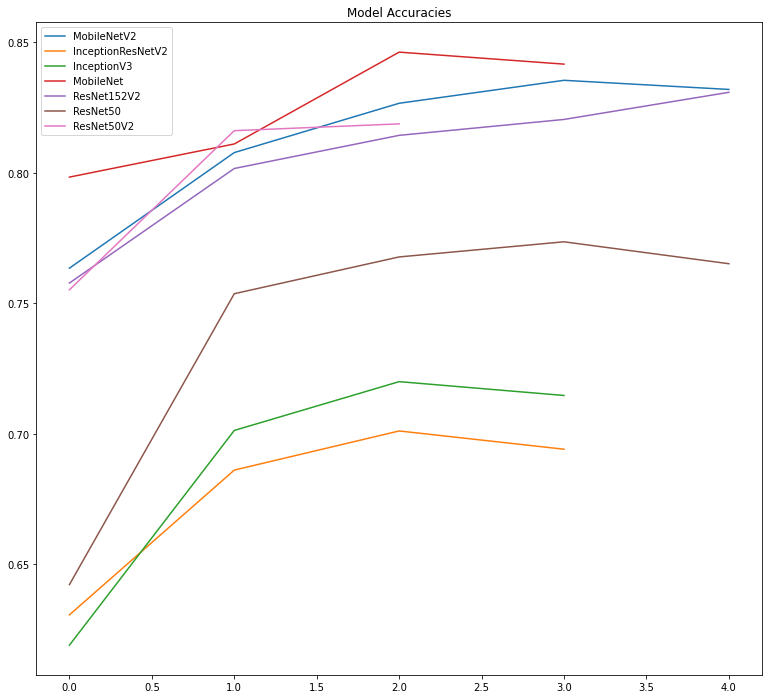

In [ ]:
def vizModels(accs, titles):     #Visualize the models result
    plt.figure(figsize=(13, 12))
    for i in range(len(accs)):
        plt.plot(accs[i])
        plt.legend(titles)
        plt.title("Model Accuracies")

legs=['MobileNetV2', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'ResNet152V2', 'ResNet50', 'ResNet50V2']
accs=[]
for leg in legs:
    accs.append(models[leg]['val_acc'])
vizModels(accs, legs)

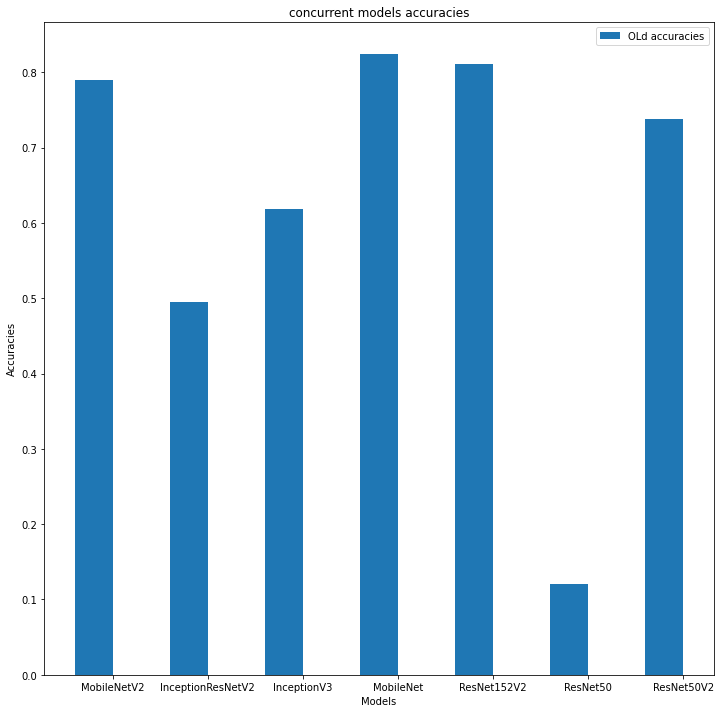

In [ ]:
# Model result comparision from before image augmentation

legs=['MobileNetV2', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'ResNet152V2', 'ResNet50', 'ResNet50V2']
old_acc=[0.7902, 0.4943, 0.6178, 0.8248, 0.8105, 0.1207, 0.7385]
max_accs=[max(i) for i in accs]

X_axis = np.arange(len(legs))
plt.figure(figsize=(12, 12))  
plt.bar(X_axis - 0.2, old_acc, 0.4, label = 'OLd accuracies')
plt.bar(X_axis + 0.2, max_accs, 0.4, label = 'Updated accuracies')  
plt.plot(max_accs)
plt.xticks(X_axis, legs)
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.title("Comparision from concurrent models with Proposed model")
plt.legend()
plt.show()

In [ ]:
# Use teh best model to fit the data in large epochs
models = tf.keras.applications.MobileNet
m = create_model(models)
start = perf_counter()
history = m.fit(train_imgs,validation_data=validation_imgs,epochs=5,verbose=1)
duration = perf_counter() - start
duration = round(duration,2)
print("trained in {duration} sec")
val_acc = history.history['val_accuracy']  

In [ ]:
pred = m.predict(test_imgs)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (test_imgs.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
# print(pred)

## Best Model: <tensorflow.python.keras.engine.functional.Functional object at 0x7fa4f4550cd0> with 82.28% accuracy on the test set

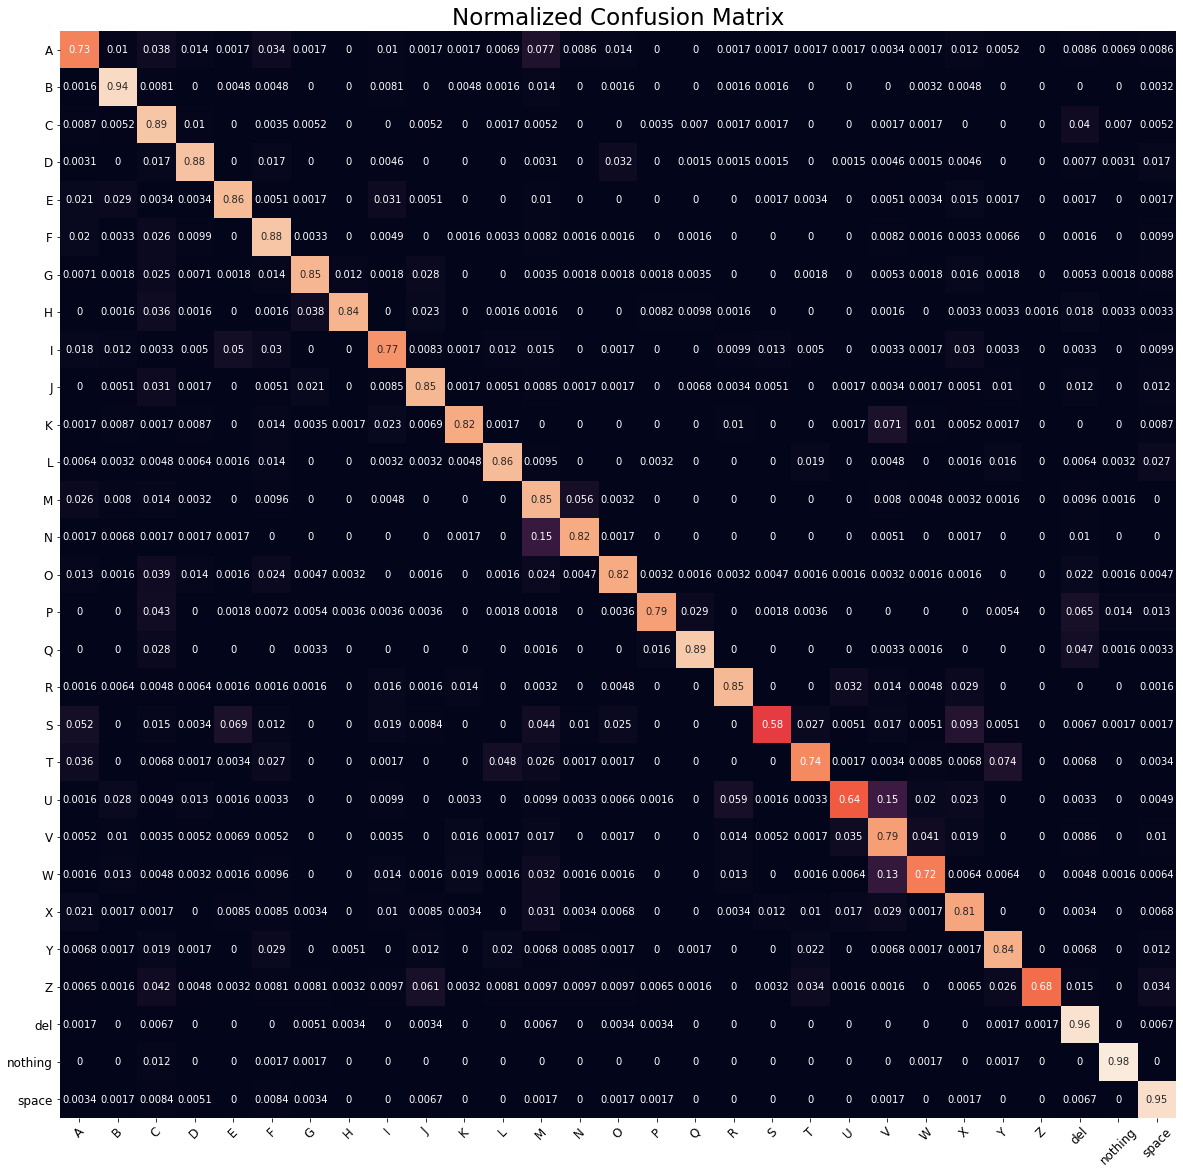

In [ ]:
# Get the accuracy on the test set
y_test = list(test['class'])
acc = accuracy_score(y_test,pred)

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,20))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Test the models perfomance on different classes

class_acs=[]
for i in np.unique(train['class']):
    tr=train[train['class'] == i]
    te=test[test['class']==i]
    tr_gen, te_gen, tr_imgs, val_imgs, te_imgs=load_images(tr, te)
    predicted=m.predict(te_imgs)
    predicted=np.argmax(predicted, axis=1)#max probable class assigned
    
    ground_truths=te['class']
    labels_=np.unique(train['class'])
    predicted_labels_names=[]
    for j in predicted:
        predicted_labels_names.append(labels_[j])
    accuracy=accuracy_score(ground_truths, predicted_labels_names)
    print(accuracy, 'for class=', i)
    class_acs.append(accuracy)

Found 2178 validated image filenames belonging to 1 classes.
Found 241 validated image filenames belonging to 1 classes.
Found 581 validated image filenames belonging to 1 classes.
0.7263339070567987 for class= A
Found 2142 validated image filenames belonging to 1 classes.
Found 237 validated image filenames belonging to 1 classes.
Found 621 validated image filenames belonging to 1 classes.
0.9355877616747182 for class= B
Found 2183 validated image filenames belonging to 1 classes.
Found 242 validated image filenames belonging to 1 classes.
Found 575 validated image filenames belonging to 1 classes.
0.8852173913043478 for class= C
Found 2118 validated image filenames belonging to 1 classes.
Found 235 validated image filenames belonging to 1 classes.
Found 647 validated image filenames belonging to 1 classes.
0.8778979907264297 for class= D
Found 2174 validated image filenames belonging to 1 classes.
Found 241 validated image filenames belonging to 1 classes.
Found 585 validated image f

Text(0.5, 1.0, 'Model Accuracies with respect to each class')

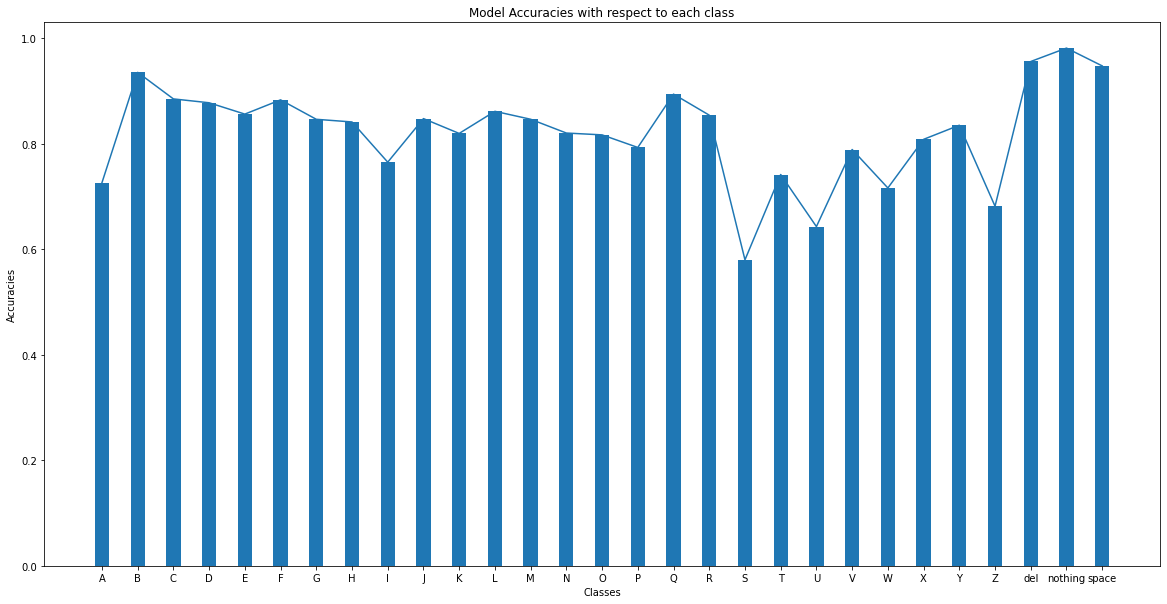

In [ ]:
# Visualize the models perfoance on different classes

plt.figure(figsize=(20, 10))
plt.bar(np.unique(train['class']), class_acs, 0.4, label = 'Updated accuracies') 
plt.plot(class_acs)
plt.xlabel('Classes')
plt.ylabel('Accuracies')
plt.title("Model Accuracies with respect to each class")